In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip install split-folders

In [4]:
! pip install torchsummary

In [5]:
! pip install pandas matplotlib

In [265]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [266]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [267]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # Also part of normalization
    transforms.Resize((128, 128))
])


In [268]:
splitfolders.ratio("CatDog", output="cat_dog",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

In [269]:
train_data = datasets.ImageFolder('cat_dog/train', transform = transform)
test_data = datasets.ImageFolder('cat_dog/val', transform = transform)

In [270]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 64,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog']
Training images available: 3199
Testing images available:  801


In [271]:
for images,labels in train_loader:
    break
images.shape

torch.Size([64, 3, 128, 128])

Label: [1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0]
Class: dog dog dog dog dog dog cat dog dog dog dog cat dog dog dog dog cat dog cat cat dog dog cat cat dog cat dog dog cat dog dog dog dog dog cat dog dog dog cat dog dog dog dog cat dog cat cat dog cat cat dog cat cat cat cat dog cat cat cat dog cat dog dog cat


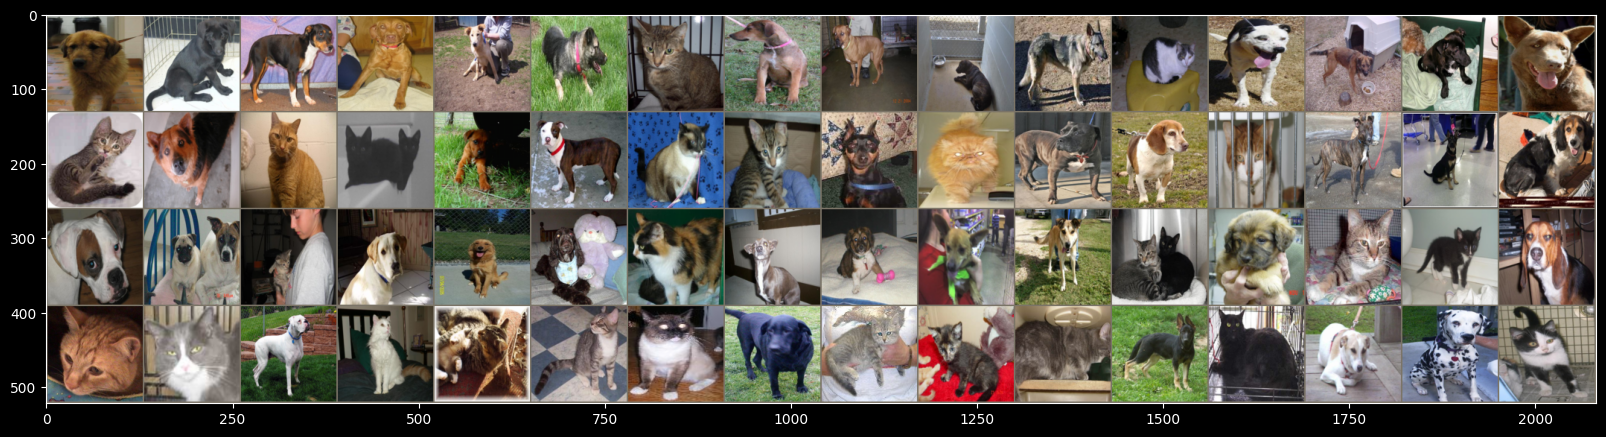

In [272]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=16)  # 16 images in a row
# Inverse normalize the images

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose((im_inv.numpy()*255).astype(np.uint8), (1, 2, 0))); # we see that dataloader has shuffle the images

In [275]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        #x = x.view(-1, 128 * 8 * 8)
        x = torch.flatten(x, 1) # Will be used with LazyLinear
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [276]:
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)

In [277]:
# count the total number of parameters in the model
summary(model.cuda(),(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 512]      16,777,728
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 64]          16,448
           Linear-10                    [-1, 2]             130
Total params: 17,018,882
Trainable params: 17,018,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.76
Params size (MB): 64.92
Esti

In [278]:
class EarlyStoppingCriterion():
    def __init__(self, patience = 5, delta = 0,  trace_func = print):

        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [281]:
import time

# epochs
epochs = 51

# loss function
lossfunc = nn.CrossEntropyLoss()

# Define the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Instantiating the early stopping
earlystopping = EarlyStoppingCriterion()

train_losses = []
train_acc = []
test_acc = []
batchLoss = []

for epoch in range(epochs):
    start_time = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in train_loader:
        images = images.to(device)  # Move images to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossfunc(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))
    # Append batch loss
    batchLoss.append(loss.item())
    
    # Testing loop
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to the appropriate device
            labels = labels.to(device)  # Move labels to the appropriate device

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_acc.append(test_accuracy)
    epoch_len = len(str(epochs))
    
    print_msg = (f'[{epoch+1:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                 f'Train Loss: {np.mean(batchLoss):.5f}, Train Accuracy: {train_accuracy:.2f}%, ' +
                 f'Test Accuracy: {test_accuracy:.2f}%')
    print(print_msg)

    earlystopping(np.mean(batchLoss), model)

    # Optionally break the loop if early stopping criteria met
    if earlystopping.early_stop:
        print("Early stopping")
        break

    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Time taken for Epoch {epoch+1}: {time_taken:.2f} seconds\n')


[ 1/51] Train Loss: 0.64168, Train Accuracy: 62.91%, Test Accuracy: 63.02%
Time taken for Epoch 1: 65.21 seconds

[ 2/51] Train Loss: 0.53940, Train Accuracy: 67.06%, Test Accuracy: 70.05%
Time taken for Epoch 2: 64.81 seconds

[ 3/51] Train Loss: 0.51553, Train Accuracy: 73.66%, Test Accuracy: 69.53%
Time taken for Epoch 3: 64.83 seconds

[ 4/51] Train Loss: 0.50783, Train Accuracy: 78.73%, Test Accuracy: 71.35%
Time taken for Epoch 4: 64.67 seconds

[ 5/51] Train Loss: 0.48730, Train Accuracy: 83.32%, Test Accuracy: 69.79%
Time taken for Epoch 5: 64.81 seconds

[ 6/51] Train Loss: 0.45124, Train Accuracy: 88.58%, Test Accuracy: 71.35%
Time taken for Epoch 6: 64.76 seconds

[ 7/51] Train Loss: 0.39678, Train Accuracy: 93.81%, Test Accuracy: 69.53%
Time taken for Epoch 7: 64.54 seconds

[ 8/51] Train Loss: 0.36743, Train Accuracy: 95.31%, Test Accuracy: 70.31%
Time taken for Epoch 8: 64.71 seconds

[ 9/51] Train Loss: 0.32819, Train Accuracy: 98.12%, Test Accuracy: 70.44%
Time taken fo

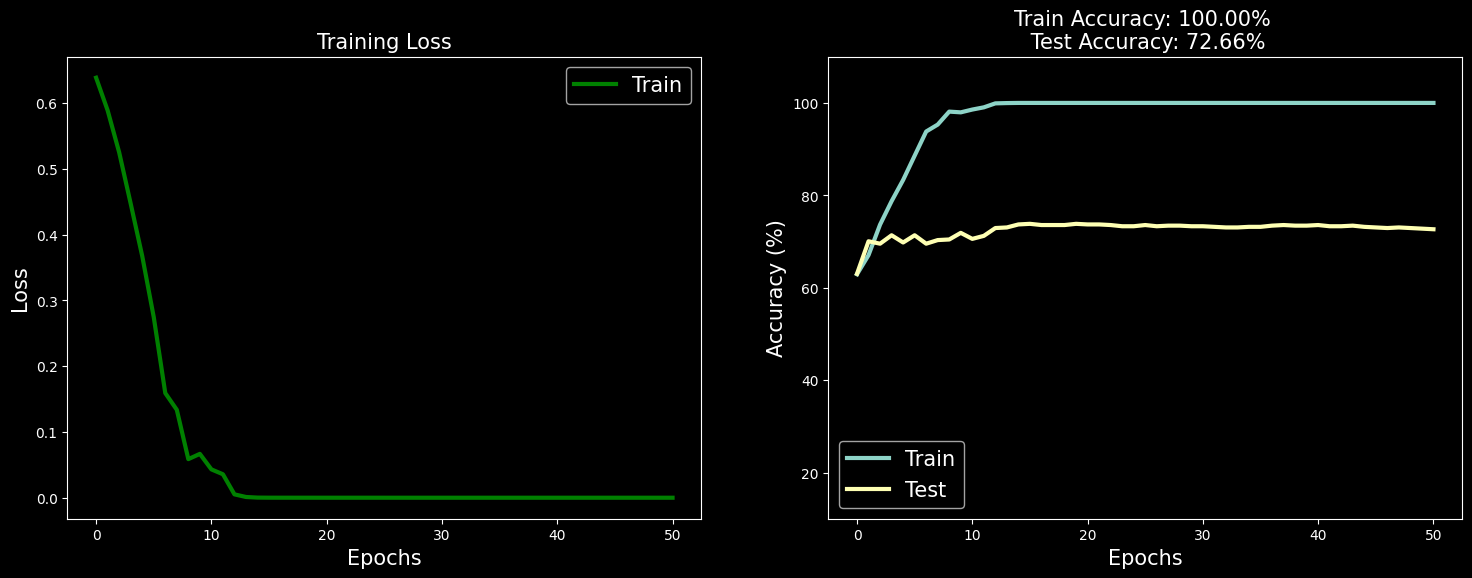

In [285]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(train_losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(train_acc, label ='Train', lw = 3)
ax[1].plot(test_acc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {train_acc[-1]:.2f}% \n Test Accuracy: {test_acc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [286]:
resnet = torchvision.models.resnet18('ResNet18_Weights.DEFAULT')

c:\Users\bhave\anaconda3\envs\pytorch_env_assign\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [287]:
# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False


In [288]:
resnet.fc = nn.Linear(512,2)

In [289]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [290]:
epochs = 20

# loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(resnet.parameters(), momentum = 0.9, lr = 0.001)


  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 resnet.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = resnet(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 resnet.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = resnet(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))


  print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.28
 epochs : 1  loss :  0.19
 epochs : 2  loss :  0.20
 epochs : 3  loss :  0.20
 epochs : 4  loss :  0.19
 epochs : 5  loss :  0.28
 epochs : 6  loss :  0.24
 epochs : 7  loss :  0.14
 epochs : 8  loss :  0.15
 epochs : 9  loss :  0.09
 epochs : 10  loss :  0.20
 epochs : 11  loss :  0.16
 epochs : 12  loss :  0.22
 epochs : 13  loss :  0.23
 epochs : 14  loss :  0.08
 epochs : 15  loss :  0.08
 epochs : 16  loss :  0.19
 epochs : 17  loss :  0.16
 epochs : 18  loss :  0.16
 epochs : 19  loss :  0.22


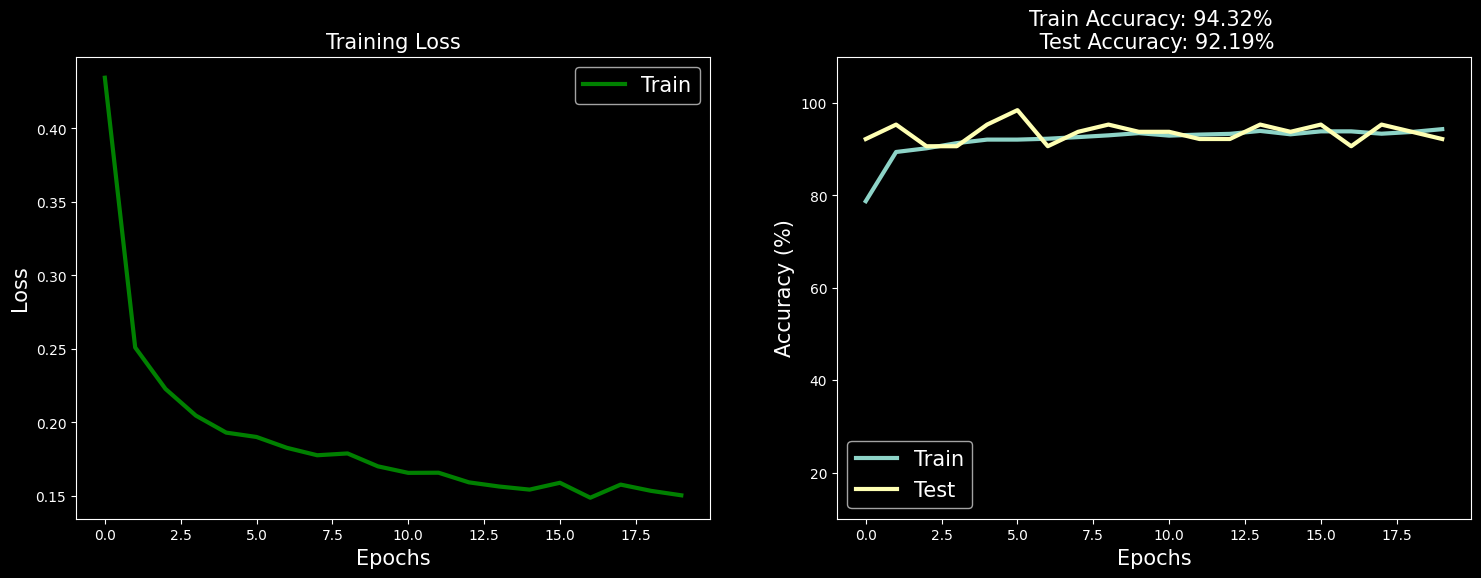

In [291]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()